<img src="./img/DSME_logo.png" alt="Scoring probabilities for direct shots [2]" width="1000">

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Bonus Point Assignment 1 - Task 1: Basketball Environment

*Important: Each task includes a task description as well as the blocks “student answer”, and “checkpoints”. “Student answer” is for placing your answer, “checkpoint” helps you to debug. Only place your answer in fields marked for this purpose, and do not modify any of the cells. In case anything outside the answer fields has been modified, we recommend restarting the notebook.*

## Library Imports

In [101]:
import pygame
import numpy as np
import gymnasium as gym
from gymnasium import Env, spaces
from gymnasium.envs.toy_text.utils import categorical_sample
from gymnasium.error import DependencyNotInstalled
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import Video
from IPython.display import display
from screeninfo import get_monitors
from typing import Optional
from render_util import render
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Task Description

Environments are a key component of RL implementations. Thus, the purpose of this task is to give an understanding of how to implement environments. For this purpose, we turn our attention to basketball. Basketball is not only a popular team sport but also an active field for research. Many scientific works aim to help teams optimize their play, that is, to score as many points as possible. We are interested in the same question, for which we will give a brief overview of the rules in basketball. 

Abstracting the complex dynamics underlying the sport [1], the ball must be thrown into the basket. If the ball is thrown in front of the so-called three-point line, the team gets three points. If the ball is thrown from behind the line, which means that the player is closer to the basket, the team gets two points. Whenever the ball misses the basket, zero points are awarded. And, of course, should not leave the field.  

In research, special attention is paid to the position from which the ball should be thrown. Simulation studies [2] provide insight into the issue. A two-dimensional analysis of the field results in varying score probabilities for direct hits depending on the field position, as shown below on the left. Additionally, data from professional games is collected and analyzed. According to [3], players throw from diverse positions, with the probability of hitting being highest when positioned close to the basket, with 63.2% in the 2018–2019 NBA season (shown in blue on the right).  

<div style="clear: both;">
  <table style="float: left;">
    <tr>
      <td> <img src="./img/goal_probabilities.png" alt="Scoring probabilities for direct shots [2]" width="415"> </td>
      <td> <img src="./img/goal_attempts.png" alt="Shot Positions [3]" width="320"> </td>
    </tr>
  </table>
  <p style="clear: both;">
  </p>
</div>  

Considering the results of the studies, a high degree of symmetry is noticeable. Using this symmetry, we establish a one-dimensional problem where the only variable determining the score probability is the distance to the basket. Thus, it is the state we observe. A discretization of the distances allows us to design a tabular environment whose essential dynamics are shown in the video below.

<div style="clear: both;">
  <table style="float: left;">
    <tr>
      <td> <img src="./img/basketball_example.gif" alt="Example of the dynamics" width="535"> </td>
      <td> <img src="./img/UML_BasketballEnv.png" alt="UML Environment" width="200"> </td>
    </tr>
  </table>
  <p style="clear: both;">
  </p>
</div>  


 
Creating this simplified basketball model is the main objective of this task. For this purpose, we provide the necessary methods for rendering. The environment will be implemented as a class, as shown above on the right. The class will be based on the toy-text environments from Gymnasium [4]. For more details on creating environments, we refer to the Gymnasium documentation ([4]).
First, in task 1.1, we will program an MDP that reproduces the dynamics described above. Then, in task 1.2, we consider how an agent can interact with this environment. Additionally, we solve the environment using dynamic programming in task 1.3.

**References**  
[1] Brancazio, Peter J. "Physics of basketball." American Journal of Physics 49.4 (1981): 356-365. [Link](https://aapt.scitation.org/doi/pdf/10.1119/1.12511)  
[2] Silverberg, Larry M., Chau M. Tran, and Taylor M. Adams. "Optimal targets for the bank shot in men's basketball." Journal of Quantitative Analysis in Sports 7.1 (2011). [Link](https://www.degruyter.com/document/doi/10.2202/1559-0410.1299/html)   
[3] Wang, Feng, and Guohua Zheng. "Examining positional difference in basketball players’ field goal accuracy using Bayesian Hierarchical Model." International Journal of Sports Science & Coaching 17.4 (2022): 848-859. [Link](https://journals.sagepub.com/doi/abs/10.1177/17479541221096772)  
[4] Towers, Mark and Terry "Gymnasium." Farama Foundation 2023. [Link](https://gymnasium.farama.org/index.html#)

---

## Task 1.1 (3 Points)

Below, we show a drawing of the MDP of our Basketball environment.

<img src="./img/basketball_mdp.png" alt="Scoring probabilities for direct shots" width="735"> </td>

We want to design the MDP with n states, counting from 0. State 0 represents the beginning of the field, while state n-1 represents the end. The length of the field is determined by the parameter `field_length`. Passing a value of 3 leads to three states 0, 1, 2 on the field. Furthermore, there are two terminal states; n, for when the agent scores, and n+1, for when the agent misses. Anywhere on the field, the agent can either throw the ball (action = 1) or move forward (action = 0). When the agent decides to move forward, reaching the next state has a probability of 100% and the agent receives a reward of 0. If the agent leaves the field via state n-1, the agent moves to n+1 and receives 0 reward. Furthermore, the agent can throw the ball in any state on the field. A throw attempt can either be successful, leading to state n, or unsuccessful, leading to state n+1. The probability of success increases linearly from a minimum value (`min_score_prob`) in the first state on the field, to a maximum value (`max_score_prob`) in the last state on the field. An unsuccessful attempt returns no reward, a successful attempt returns a reward of 3 if it was made in front of the line, and a reward of 2 if it was made behind the line. The position of the line is flexible and is passed to the environment as parameter `line_position`. If a value of 2 is passed, it means that state 2 is the first state behind the line.  

The goal of this task is to transfer the dynamics described above into code. For this purpose, we use an implementation similar to the toy-text environments in Gymnasium. In these environments, the MDP is implemented in the `__init__` of the environment class as an attribute called `self.P`. This `self.P` is a dictionary that contains the available actions for all states, which are again structured as dictionaries. These dictionaries lead to possible transitions from the resulting state action pair. This results in the following form:

&ensp; $ \mathrm{self.P} = \{$   
&ensp; &ensp; $ s_0: \{ a_0: [\mathrm{transitions}(s_0, a_0)], a_1: [\mathrm{transitions}(s_0, a_1)], a_2: [...], ... \},$   
&ensp; &ensp; $ s_1: \{ a_0: [\mathrm{transitions}(s_1, a_0)], a_1: [...], ... \},$   
&ensp; &ensp; $ s_2: \{ a_0: [...], ... \},$   
&ensp; &ensp; $...$   
&ensp; $\}$   

The transitions listed here are arrays of tuples, where each tuple represents a single possible transition in the form of

&ensp; $[\mathrm{transitions}(s_i, a_j)] = [(p(s'_0 | s_i, a_j), s'_0, r, t), (p(s'_1 | s_i, a_j), s'_1, r, t), (...)] $

where we use the notation

&ensp; $s_i$ = state i (int),   
&ensp; $a_j$ = action j (int),   
&ensp; $s'_k$ = successor states (int),   
&ensp; $p(s'_k | s_i, a_j)$ = state transition probability (float),         
&ensp; $r$ = reward (float), and     
&ensp; $t$ = termination (boolean, True when the entry leads to a terminating state).   
 
Note that the reward and information about termination and successor states differ depending on the previous state and action; however, we neglected this dependency above for the sake of simple notation. By inserting all available information, we obtain the dynamics of our environment via `self.P`. Below, we give an example of `self.P` applied to our basketball environment. Here, parameters `min_score_prob=0.0`, `max_score_prob=0.9`, `field_length=6`, and `line_position=2` have been set. It follows the form:

&ensp; `self.P`= $\{$   
<div style="clear: both;">
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;font-weight:unset;padding:2px 5px;border-style:none;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:2px 5px;border-style:none;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-i0og{color:#000000}
</style>
<table class="tg" style="margin-left: 20px; border-collapse: collapse; cellspacing: 1px;">
  <tr>
    <td class="tg-i0og" align="left" > 0: {</td>
    <td class="tg-031e" align="left" > 0: [(1, 1, 0, False)],</td>
    <td class="tg-031e" align="left" > 1: [(0.0, 6, 3, True), (1.0, 7, 0, True)] </td>
    <td class="tg-031e" align="left" > } </td>
  </tr>
  <tr>
    <td class="tg-i0og"> 1: { </td>
    <td class="tg-031e"> 0: [(1, 2, 0, False)], </td>
    <td class="tg-031e"> 1: [(0.18, 6, 3, True), (0.820001, 7, 0, True)] </td>
    <td class="tg-031e"> } </td>
  </tr>  
  <tr>
    <td class="tg-i0og"> 2: { </td>
    <td class="tg-031e"> 0: [(1, 3, 0, False)], </td>
    <td class="tg-031e"> 1: [(0.36, 6, 2, True), (0.64, 7, 0, True)] </td>
    <td class="tg-031e"> } </td>
  </tr>
  <tr>
    <td class="tg-i0og"> 3: { </td>
    <td class="tg-031e"> 0: [(1, 4, 0, False)], </td>
    <td class="tg-031e"> 1: [(0.54, 6, 2, True), (0.459999, 7, 0, True)] </td>
    <td class="tg-031e"> } </td>
  </tr>
  <tr>
    <td class="tg-i0og"> 4: { </td>
    <td class="tg-031e"> 0: [(1, 5, 0, False)], </td>
    <td class="tg-031e"> 1: [(0.72, 6, 2, True), (0.28, 7, 0, True)] </td>
    <td class="tg-031e"> } </td>
  </tr>
  <tr>
    <td class="tg-i0og"> 5: { </td>
    <td class="tg-031e"> 0: [(1, 7, 0, True)], </td>
    <td class="tg-031e"> 1: [(0.9, 6, 2, True), (0.099999, 7, 0, True)] </td>
    <td class="tg-031e"> } </td>
  </tr>
  <tr>
    <td class="tg-i0og"> 6: { </td>
    <td class="tg-031e"> 0: [(1, 6, 0, True)], </td>
    <td class="tg-031e"> 1: [(1, 6, 0, True)] </td>
    <td class="tg-031e"> } </td>
  </tr>
  <tr>
    <td class="tg-i0og"> 7:  {</td>
    <td class="tg-031e"> 0: [(1, 7, 0, True)] </td>
    <td class="tg-031e"> 1: [(1, 7, 0, True)] </td>
    <td class="tg-031e"> } </td>
  </tr>
</table>
<span style='font-size:9px;'>   
</div>   

&ensp; $\}$

In the block below, we provide the initiation of the class `BasketballEnv`, including `__init__`, where `self.P` shall be implemented. We also provide all other important variables; thus, you only have to extend the existing code within the highlighted area in the block below. 


*Remark: In the MDP above, the terminal states have actions. In an MDP, the available actions per state can vary, so that in some implementations, no actions are assigned to the terminal states. Here, however, we assign the same actions to all states to simplify the implementation.*

### Student Answer

In [102]:
class BasketballEnv(Env):
    # Modes for rendering:
    metadata = {
        "render_modes": ["human", "rgb_array", None],
        "render_fps": 4,
    }
    
    def __init__(self, min_score_prob=0.0, max_score_prob=0.9, line_position = 3, field_length = 10, render_mode=None):
        """ Initializes the environment and defines dynamics.
        
        Please DON'T change the names of the variables that are already defined in this method.
        """
        self.render_mode = render_mode
        self.render_time = 1 # one image per second
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization. "
            )
        if self.render_mode != "text" and self.render_mode != None:
            self.render_width = 130
            self.window_size = ((field_length+1)*self.render_width, self.render_width)
            self.cell_size = (self.render_width, self.render_width)
            self.window_surface = None
        self.state = 0 # starting state
        self.laststate = None
        self.field_length = field_length # max length of the field
        self.line_position = line_position # position of the three point line
        self.action_space = spaces.Discrete(2) # 0 = move, 1 = throw
        self.observation_space = spaces.Discrete(self.field_length+2)
        self.P = {}

# YOUR CODE HERE
        score_range = max_score_prob-min_score_prob
        score_step = score_range/(field_length-1)
        for i in range(self.field_length-1):
            self.P[i] = {
                0:[(1,i+1,0,False)],
                1:[
                    (i*score_step+min_score_prob,self.field_length, 3 if i < self.line_position else 2 ,True),
                    (1-(i*score_step+min_score_prob),self.field_length+1,0,True)
                    ]
                }
        self.P[self.field_length-1] = {
                0:[(1,self.field_length+1,0,False)],
                1:[
                    (max_score_prob,self.field_length, 3 if i < self.line_position else 2 ,True),
                    (1-max_score_prob,self.field_length+1,0,True)
                    ]
                }
        self.P[self.field_length] = {0:[(1,self.field_length,0,True)],1:[(1,self.field_length,0,True)]}
        self.P[self.field_length+1] = {0:[(1,self.field_length+1,0,True)],1:[(1,self.field_length+1,0,True)]}

### Checkpoint

Below, we provide some tests for you to check whether your code works. Please consider using them for debugging purposes only.

In [103]:
# Test environment for performing sanity checks
gym.logger.set_level(40)
field_length = 5
line_position = 3
test_env = BasketballEnv(field_length = field_length, line_position = line_position)

In [104]:
# Is the successor state correct?
s = 0
a = 0
assert test_env.P[s][a][0][1] == s+1

In [105]:
# Used for grading. Do not change.

In [106]:
# Do we reach the right states if we try to score?
s = 3
a = 1
assert test_env.P[s][a][0][1] == 5 or test_env.P[s][a][0][1] == 6

In [107]:
# Used for grading. Do not change.

In [108]:
# Are the probabilities correct?
s = 0
a = 1
assert test_env.P[s][a][0][0] == 0

In [109]:
# Used for grading. Do not change.

---

## Task 1.2 (2 Points)

By implementing the MDP in `self.P`, you have laid the foundation for using the environment to train agents. However, we still lack the necessary methods to allow interaction with the environment. Agents must be able to explore the environment using the method `step`. In addition, we need to be able to reset the environment after sampling, using the method `reset`. In the following, your task is to design these two methods. The notes below will provide guidance.

`step`:
- Initially, the current state should be cached in `self.laststate`.
- For a given action, the method returns the new state, reward, and info about termination, as described in task 1.1, in exactly this order.
- A new state is selected based on the current state and the given action using `self.P`. The current state can be retrieved from `self.state`. The selection follows the given probabilities.
- The toy_text environments use a function called `categorical_sample`, which can simplify sampling. Information about how to use the function can be retrieved, for example, from the Frozen Lake implementation in the Gymnasium package.

`reset`:
- For each call, this method resets all relevant variables.
- The method returns the initial state.
- The method always resets to state 0.
- The method resets `self.laststate` to `None`

### Student Answer

In [110]:
def reset(self):
    """ Reset the environment.
    
    Args: 
        None
    Returns: 
        Initial state
    """
        
# YOUR CODE HERE
    self.state = 0
    self.laststate=None
    return self.state

In [111]:
def step(self, action):
    """ Take a step in the environment.
    
    Args:
        action
    Returns:
        next state, reward, termination
    """
    
# YOUR CODE HERE
    self.laststate = self.state
    transitions = self.P[self.state][action]
    i = categorical_sample([t[0] for t in transitions], self.np_random)
    p, s, r, d= transitions[i]
    self.state = s
    return (s, r, d)
    

In [112]:
# Adding the methods to the class of the environment

setattr(BasketballEnv, 'reset', reset)
setattr(BasketballEnv, 'step', step)
setattr(BasketballEnv, 'render', render)

### Checkpoint

In [113]:
field_length = 10
line_position = 5
test_env = BasketballEnv(field_length = field_length, line_position = line_position)

In [114]:
# Does the reset work?
test_env.state = 8
new_state = test_env.reset()
assert test_env.state == 0

In [115]:
# Used for grading. Do not change.


In [116]:
# Does the step work?
test_env.state = 5
test_env.step(0) # moving forward
assert test_env.state == 6


In [117]:
# Used for grading. Do not change.

---

## *Debug: Testing the Environment*

By defining all the factors and dynamics, as well as adding methods for interacting with the environment, we have all the elements we need to use it. For better traceability, we import a visualization based on the `pygame` package. 

Further down, we make it possible to set a policy and observe the behavior of an agent in the environment based on it. Please consider using this to debug the previous code, as the environment is required for the next task. The policy contains a prescribed action for each state. Activating the block leads to the playback of a video that should reproduce the desired behavior.

In [118]:
def evaluate(env, policy, file, num_runs=5):
    """ Evaluates the environment based on a policy.

    Please use this method to debug your code for the environment.

    Args:
        env: Environment we want to use. 
        policy: Numpy array of shape (num_states, num_actions), for each state the array contains
            the probabilities of entering the successor state based on the associated action. 
        file: File used for storing the video.
        num_runs: Number of runs displayed.
    """
    
    frames = []  # collect rgb_image of agent env interaction
    video_created = False
    for _ in range(num_runs):
        done = False
        obs = env.reset()
        while not done:
            action =  np.random.choice(np.flatnonzero(np.isclose(policy[obs], max(policy[obs]), rtol=0.0001)))
            out = env.render()
            frames.append(out)
            obs, reward, done = env.step(action)
            if done:
                out = env.render()
                frames.append(out)
                
    # create animation out of saved frames
    if all(frame is not None for frame in frames):
        fig = plt.figure(figsize=(10, 6))
        plt.axis('off')
        img = plt.imshow(frames[0][0])
        def animate(index):
            img.set_data(frames[index][0])
            return [img]
        anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
        plt.close()
        anim.save(file, writer="ffmpeg", fps=2)
        video_created = True

In [119]:
# For debug consider varying the parameters and changing the policy. Restarting the cell leads to video output

env = BasketballEnv(min_score_prob = 0.0, max_score_prob = 0.8, line_position = 2, field_length = 10, render_mode = "rgb_array")
policy = np.array([[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0]]) # probabilies for actions per state
video_file_1 = "basketball.mp4"
evaluate(env, policy, video_file_1)
Video(video_file_1, html_attributes="loop autoplay")

---

## Task 1.3 (4 Points)

We now have an environment that we can use to train an agent. Training requires a training method, for which we will use dynamic programming. For training the agent, we asked a student assistant to implement an `Agent` class capable of learning an optimal policy via policy iteration. Unfortunately, some errors occurred while the information was transferred from the textbook. Your task is to find the errors and fix the code. For this purpose, we show the algorithm for policy iteration below, as presented in [5].  

<img src="./img/policy_iteration.png" alt="Policy Iteration Algorithm [5]" width="735"> </td>

Please correct the code below. Only some methods of the class `Agent` are flawed. The potentially flawed methods are commented out in the code provided below. Please copy *all* of them into the student answer block an correct them there to fix the Policy Iteration implementation.

**References**   
[5] Sutton, Richard S., and Andrew G. Barto, "Dynamic Programming", in *Reinforcement learning: An introduction*.  MIT press, 2018.  

### Student Answer
Please enter your correct code below:

In [120]:
class Agent():
    
    def __init__(self, env, gamma=0.9, update_threshold=1e-6):
        """ Initializes the Agent.
        
        The agent takes properties of the environment and stores them for training.

        Args:
            env: Environment used for training.
            gamma: Discount factor.
            update_threshold: Stopping distance for updates of the value function.
        """
        
        self.mdp = (env.unwrapped.P, env.observation_space.n, env.action_space.n)
        self.update_threshold = update_threshold # stopping distance as criteria for stopping policy evaluation
        self.state_value_fn = np.zeros(self.mdp[1]) # a table leading from state to value expectations
        # Create random policy
        self.policy = []
        for state in range(self.mdp[1]):
            random_entry = np.random.randint(0, 1)
            self.policy.append([0 for _ in range(self.mdp[2])])
            self.policy[state][random_entry] = 1
        self.gamma = gamma # discount factor
        self.iteration = 0
        
    def reset(self):
        """ Resets the agent. """
        self.state_value_fn = np.zeros(self.mdp[1])
        self.policy = []
        for state in range(self.mdp[1]):
            random_entry = np.random.randint(0, 1)
            self.policy.append([0 for _ in range(self.mdp[2])])
            self.policy[state][random_entry] = 1
        self.iteration = 0

    def get_greedy_action(self, state):
        """ Choose an action based on the policy. """
        action = np.random.choice(np.flatnonzero(np.isclose(self.policy[state], max(self.policy[state]), rtol=0.01)))
        return action
    
    def visualize(self):
        """ Visualize the Q-function. """
        x_axis = 1
        y_axis = self.mdp[1]-2 
        vmin = min(self.state_value_fn)
        vmax = max(self.state_value_fn)
        X1 = np.reshape(self.state_value_fn[:-2], (x_axis, y_axis))
        fig, ax = plt.subplots(1, 1)
        cmap = plt.colormaps["Blues_r"]
        cmap.set_under("black")
        img = ax.imshow(X1, interpolation="nearest", vmin=vmin, vmax=vmax, cmap=cmap)
        ax.axis('off')
        ax.set_title("Values of the state value function on the field")
        for i in range(x_axis):
            for j in range(y_axis):
                ax.text(j, i, str(X1[i][j])[:4], fontsize=12, color='black', ha='center', va='center')
        plt.show()
        
    def render_policy(self):
        """ Print the current policy. """
        print('Policy of the agent:')
        out = ' | '
        render = out
        for i in range(self.mdp[1]-2):
            token = ""
            if self.policy[i][0] > 0:   # move
                token += "Move"
            if self.policy[i][1] > 0:   # up
                token += "Throw"
            if len(token) > 5:
                token = 'Move or Throw'
            render += token + out
        print(render) 
  
    """
    def train(self):
        policy_stable = False
        total_sweeps = 0
        for i in range(100):
            # Policy Evaluation
            total_sweeps += self.policy_evaluation()
            # Policy Improvement
            policy_stable = self.policy_improvement()
            self.iteration = 1
        print('Sweeps required for convergence ', str(total_sweeps))
        print('Iterations required for convergence ', str(self.iteration))

    def policy_evaluation(self): 
        # in place version
        sweeps = 0
        stable = False
        delta = 10
        for i in range(1):
            sweeps += 1
            for state in range(self.mdp[1]):
                old_state_value = self.state_value_fn[state]
                new_state_value = 0
                # sum over potential actions
                for action in range(self.mdp[2]):
                    new_state_value += self.get_policy_value(state, action)
                self.state_value_fn[state] = new_state_value
                delta = max(delta, np.abs(old_state_value - self.state_value_fn[state]))
            if delta < self.update_threshold:
                stable = True
        return sweeps

    def get_policy_value(self, state, action):
        # Value expectation considering the policy
        policy_value = 0
        for transition in self.mdp[0][state][action]:
            transition_prob = transition[0] # prob of next state
            successor_state = transition[1] # value/name of next state
            reward = transition[2] # reward of next state
            policy_value += self.policy[state][action] * transition_prob * (reward + self.state_value_fn[successor_state])
        return policy_value
    
    def get_action_value(self, state, action):
        # Value expectation without considering the policy
        action_value = 0
        for transition in self.mdp[0][state][action]:
            transition_prob = transition[0] # prob of next state
            successor_state = transition[1] # value/name of next state
            reward = transition[2] # reward of next state
            action_value += transition_prob * (reward + self.state_value_fn[successor_state]) 
        return action_value

    def policy_improvement(self):
        policy_stable = True
        current_policy = self.policy # Cache current policy
        best_policy = []
        for state in range(self.mdp[1]):
            best_policy.append([0 for _ in range(self.mdp[2])])
            # Calculate best possible policy based on current value function
            action_values = []
            for action in range(self.mdp[2]):
                action_values.append(self.get_action_value(state, action))
            best_actions = np.where(action_values == max(action_values))[0]
            for index in best_actions:
                best_policy[state][index] = 1
            best_policy[state] = [best_policy[state][action] / len(best_actions)
                                  for action in range(self.mdp[2])]
            # If the current policy is not the best policy, update it
            if not np.array_equal(current_policy[state], best_policy[state]):
                policy_stable = False
                self.policy[state] = best_policy[state]
        return policy_stable
    """


# YOUR CODE HERE
    def train(self):
        policy_stable = False
        total_sweeps = 0
        while not policy_stable:
            # Policy Evaluation
            total_sweeps += self.policy_evaluation()
            # Policy Improvement
            policy_stable = self.policy_improvement()
            self.iteration += 1
        print('Sweeps required for convergence:', total_sweeps)
        print('Iterations required for convergence:', self.iteration)

    def policy_evaluation(self): 
        env = self.mdp[0]
        state_len = self.mdp[1]
        action_len = self.mdp[2]
        sweeps = 0
        while True:
            sweeps += 1
            delta = 0
            for state in range(state_len):
                old_state_value = self.state_value_fn[state]
                new_state_value = 0
                for action in range(action_len):
                    for transition in self.mdp[0][state][action]:
                        transition_prob, next_state, reward, termiantion = transition
                        new_state_value += self.policy[state][action] *(reward+self.gamma*self.state_value_fn[next_state])
                self.state_value_fn[state] = new_state_value
                delta = max(delta, np.abs(old_state_value - new_state_value))
            if delta < self.update_threshold:
                break
        return sweeps

    def get_policy_value(self, state, action):
        policy_value = 0
        for transition in self.mdp[0][state][action]:
            transition_prob = transition[0] # prob of next state
            successor_state = transition[1] # value/name of next state
            reward = transition[2] # reward of next state
            policy_value += transition_prob * (reward + self.gamma * self.state_value_fn[successor_state])
        return policy_value
    
    def get_action_value(self, state, action):
        action_value = 0
        for transition in self.mdp[0][state][action]:
            transition_prob, successor_state, reward, termination = transition # prob of next state
            if termination:
                action_value += transition_prob * reward
            else:
                action_value += transition_prob * (reward + self.gamma * self.state_value_fn[successor_state]) 
        return action_value

    def policy_improvement(self):
        policy_stable = True
        env = self.mdp[0]
        state_len = self.mdp[1]
        action_len = self.mdp[2]
        current_policy = self.policy
        best_policy = []
        for state in range(state_len):
            old_action = self.policy[state]
            pi_s = np.argmax([self.get_action_value(state, action) for action in range(action_len)])
            best_policy.append([0 for _ in range(action_len)])
            best_policy[state][pi_s] = 1
            if not np.array_equal(current_policy[state], best_policy[state]):
                policy_stable = False
                self.policy[state] = best_policy[state]
        return policy_stable        

### Checkpoint

In [121]:
field_length = 12
line_position = 6
test_env = BasketballEnv(field_length = field_length, line_position = line_position)
test_agent = Agent(test_env, gamma=0.9, update_threshold=1e-6)

mdp = test_agent.mdp
env = mdp[0]
state_len = mdp[1]
action_len = mdp[2]
test_agent.policy[1][1]


0

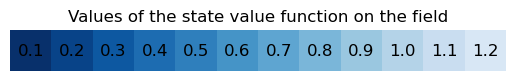

In [122]:
# Does the visualization work?
test_agent.state_value_fn = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
test_agent.visualize()
test_agent.reset()

In [123]:
# Used for grading. Do not change.

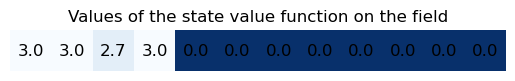

In [124]:
# Can we evaluate a policy?
test_agent.policy = [[0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
test_agent.policy_evaluation()
test_agent.visualize()
test_agent.reset()

In [125]:
# Used for grading. Do not change.

[[1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0]]

Sweeps required for convergence: 28
Iterations required for convergence: 5


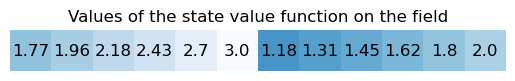

Policy of the agent:
 | Move | Move | Move | Move | Move | Throw | Move | Move | Move | Move | Move | Throw | 


In [126]:
# Does the training work?
display(test_agent.policy)
test_agent.train()
test_agent.visualize()
test_agent.render_policy()


In [127]:
# Used for grading. Do not change.

---

## Finally: Training the Agent (1 Point)

We verify that the environment can be used to train an agent with policy iteration to generate an optimal policy. For this, we create an environment, train an agent, and show the results. An optimal policy should be displayed in the video below. In case errors occur, please check your answers up to this point.

In [128]:
env = BasketballEnv(min_score_prob = 0.1, max_score_prob = 0.95, line_position = 2, field_length = 8, render_mode = "rgb_array")
test_agent = Agent(env, gamma = 0.99)
test_agent.train()

video_file_2 = "basketball_training.mp4"
evaluate(env, test_agent.policy, video_file_2)
Video(video_file_2, html_attributes="loop autoplay")

Sweeps required for convergence: 11
Iterations required for convergence: 3


In [129]:
# This is the end of task 1, please proceed with task 2